# Week 7 Notebook for LSTM model building. Need to get a MAPE value for the poster.

In [80]:
from _Setup import *
from _Functions import *

In [81]:
# Import the scaler
with open(scalers_file, "rb") as file:
    scalers = pickle.load(file)
    
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Ensure scalers work
atlanta_scaler_info = scalers['Atlanta Field Office']
print(atlanta_scaler_info)

# Display the min and max values used for scaling
print("Min values:", atlanta_scaler_info.data_min_)
print("Max values:", atlanta_scaler_info.data_max_)

# Display the feature range
print("Feature range:", atlanta_scaler_info.feature_range)

# Display the scale and min values used for transformation
print("Scale:", atlanta_scaler_info.scale_)
print("Min:", atlanta_scaler_info.min_)

MinMaxScaler()
Min values: [521.]
Max values: [2141.]
Feature range: (0, 1)
Scale: [0.00061728]
Min: [-0.32160494]


In [82]:
# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row

In [83]:
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')

In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

# Define the single top configuration
top_config = {
        'input_size': 12,
        'learning_rate': 0.0001,
        'dropout_1': 0.5,
        'dropout_2': 0.5,
        'dropout_3': 0.5,
        'units_1': 12,
        'units_2': 512,
        'units_3': 256,
        'units_4': 64,
        'units_5': 6,
        'batch_size': 16,
        'epochs': 100,
        'patience': 5
    }
# Initialize a DataFrame to store the results
top_model_results = pd.DataFrame(columns=["config_id", "sector", "train_loss", "val_loss", "predictions", "MAPE"])

# Use the single configuration to train the model
config_id = 1
train_data, val_data = validation_split(sector_train_scaled, train_size=top_config['input_size'], validation_size=6)

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = top_config['input_size']
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    val_data_np = np.array(train_data[index_integer][split_index:])
    val_data_y_np = np.array(val_data[index_integer][split_index:])
    
    # Check the shapes of the data
    print(f'Train data shape for {index}: {train_data_np.shape}')
    print(f'Validation data shape for {index}: {val_data_np.shape}')
    
    # Reshape the data to fit the model's input requirements for LSTM
    train_data_np = train_data_np.reshape(-1, top_config['input_size'], 1)
    train_data_y_np = train_data_y_np.reshape(-1, 6)
    val_data_np = val_data_np.reshape(-1, top_config['input_size'], 1)
    val_data_y_np = val_data_y_np.reshape(-1, 6)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np, dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=top_config['learning_rate'])

    # Define the LSTM neural network model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(top_config['input_size'], 1)))
    nn_model.add(LSTM(units=top_config['units_1'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_1']))
    nn_model.add(LSTM(units=top_config['units_2'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_2']))
    nn_model.add(LSTM(units=top_config['units_3'], return_sequences=True))
    nn_model.add(Dropout(top_config['dropout_3']))
    nn_model.add(LSTM(units=top_config['units_4']))
    nn_model.add(Dense(units=top_config['units_5'], activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=top_config['patience'], restore_best_weights=True)
    
    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=top_config['epochs'], batch_size=top_config['batch_size'], validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping], verbose=1)  

    test_input = np.array(sector_train_scaled.iloc[index_integer][-top_config['input_size']:]).reshape(-1, top_config['input_size'], 1)
    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)
    predictions = nn_model.predict(test_input_tensor)
    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())
    sector_predictions = predictions.flatten()

    # Store the results in the DataFrame
    top_model_results = pd.concat([top_model_results, pd.DataFrame({
        "config_id": [config_id],
        "sector": [index],
        "train_loss": [train_progress.history['loss']],
        "val_loss": [train_progress.history['val_loss']],
        "predictions": [predictions.flatten()],
        "MAPE": [mape_by_time_step]
    })], ignore_index=True)

Train data shape for Atlanta Field Office: (12, 12)
Validation data shape for Atlanta Field Office: (28, 12)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.1520 - val_loss: 0.2023
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1487 - val_loss: 0.1982
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.1455 - val_loss: 0.1940
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.1416 - val_loss: 0.1898
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1382 - val_loss: 0.1855
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1348 - val_loss: 0.1810
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1320 - val_loss: 0.1765
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1276 - val_loss: 0.1717
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1245 - val_loss: 0.1667
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1191 - val_loss: 0.1614
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\super\AppData\Local\Temp\ipykernel_27168\2931243083.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_model_results = pd.concat([top_model_results, pd.DataFrame({


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3524 - val_loss: 0.5951
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3484 - val_loss: 0.5841
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.3450 - val_loss: 0.5730
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3407 - val_loss: 0.5616
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.3376 - val_loss: 0.5499
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3334 - val_loss: 0.5378
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.3282 - val_loss: 0.5251
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3245 - val_loss: 0.5117
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.3206 - val_loss: 0.4977
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3136 - val_loss: 0.4829
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.3108 - val_loss: 0.4671
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.30

In [90]:
# Function to calculate MAPE for each term
def calculate_mape_per_term(actual, predicted):
    return [mean_absolute_percentage_error([actual[i]], [predicted[i]]) for i in range(len(actual))]


# Initialize a DataFrame to store the MAPE results
mape_results = pd.DataFrame(columns=["sector", "MAPE"])

# Iterate over each sector and calculate MAPE
for sector in top_model_results['sector'].unique():
    actual_values = test_data.loc[test_data.index == sector].values.flatten()
    predicted_values = np.concatenate(top_model_results[top_model_results['sector'] == sector]['predictions'].values)
    
    # Calculate MAPE for each term
    mapes = calculate_mape_per_term(actual_values, predicted_values)
    
    # Save the MAPE values to the new DataFrame
    mape_results = pd.concat([mape_results, pd.DataFrame({"sector": [sector], "MAPE": [mapes]})], ignore_index=True)


top_model_results['MAPE'] = mape_results['MAPE']

In [92]:
# Load the pickle file into a DataFrame
with open("C:/AA-Capstone/Model_Outputs/lstm_model_results.pkl", 'rb') as file:
    lstm_model_results = pickle.load(file)
    
# Initialize a DataFrame to store the average MAPE for each config_id
average_mape_results = pd.DataFrame()

# Get the unique config_ids
config_ids = lstm_model_results['config_id'].unique()

# Iterate through each config_id
for config_id in config_ids:
    # Filter the model_results DataFrame to only include rows for the current config_id
    filtered_results = lstm_model_results[lstm_model_results['config_id'] == config_id]

    # Create a DataFrame to store MAPE values for each sector
    mape_df = pd.DataFrame(columns=range(6))

    # Iterate through the filtered results and extract MAPE values
    for index, row in filtered_results.iterrows():
        mape_df.loc[row['sector']] = row['MAPE']

    # Calculate the mean MAPE for each time step
    average_mape = mape_df.mean()

    # Create a DataFrame to store the average MAPE for each time step
    average_mape_df = pd.DataFrame(average_mape, columns=[f'config_id_{config_id}'])

    # Append the average MAPE for the current config_id to the results DataFrame
    average_mape_results = pd.concat([average_mape_results, average_mape_df], axis=1)

MAPE for each time step

In [93]:
average_mape_results

,config_id_1
0,0.909389
1,0.783930
2,0.800806
3,0.630037
4,2.007464
5,1.141098


Average Mape for this model

In [94]:
# Calculate the mean of each column
column_means = average_mape_results.mean()

print("After more tuning, average mape is now:")
print(column_means)

After more tuning, average mape is now:
config_id_1    1.045454
dtype: float64


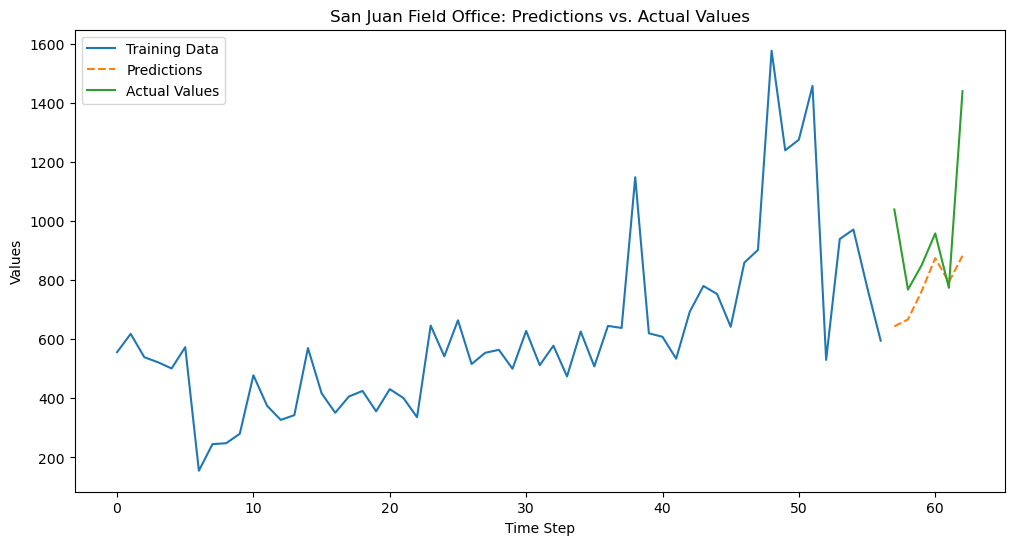

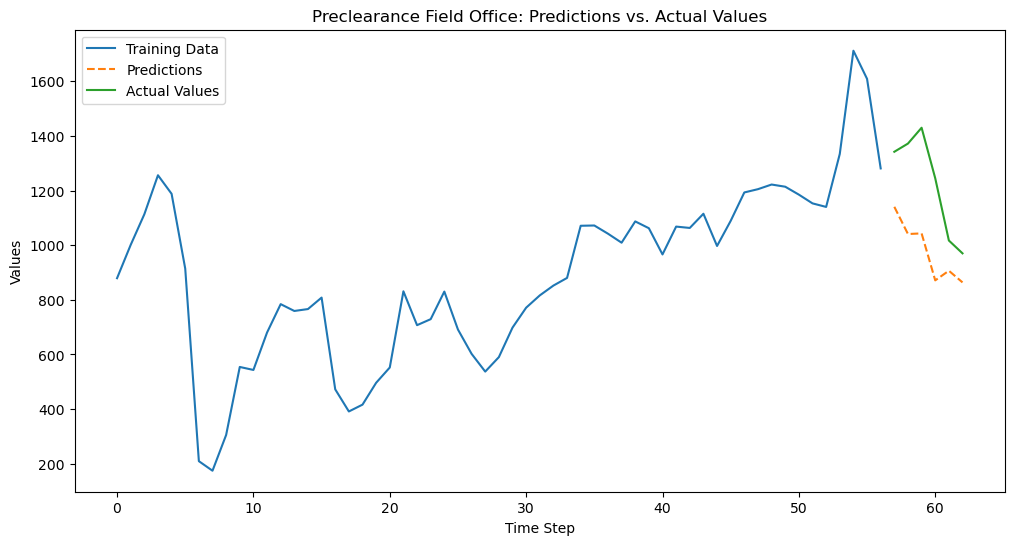

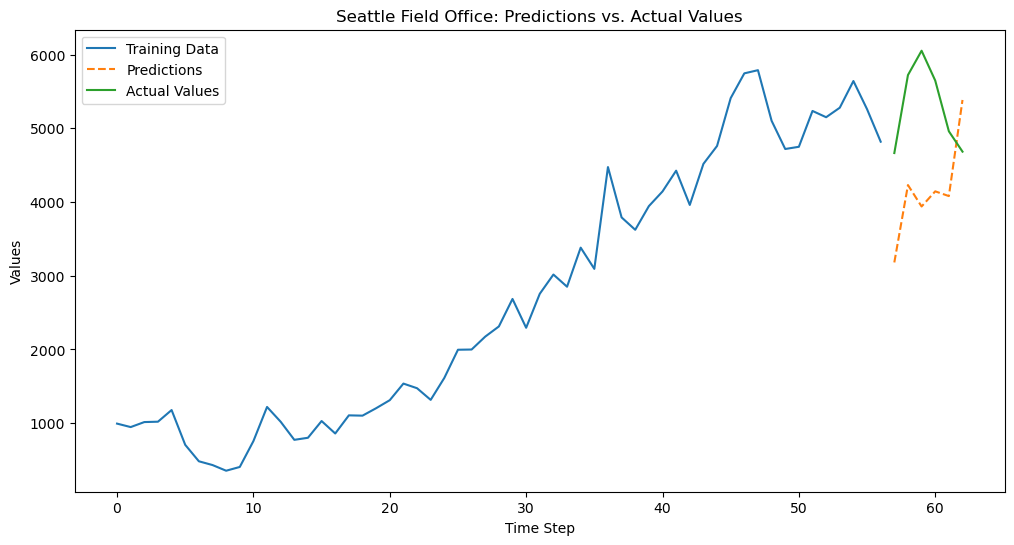

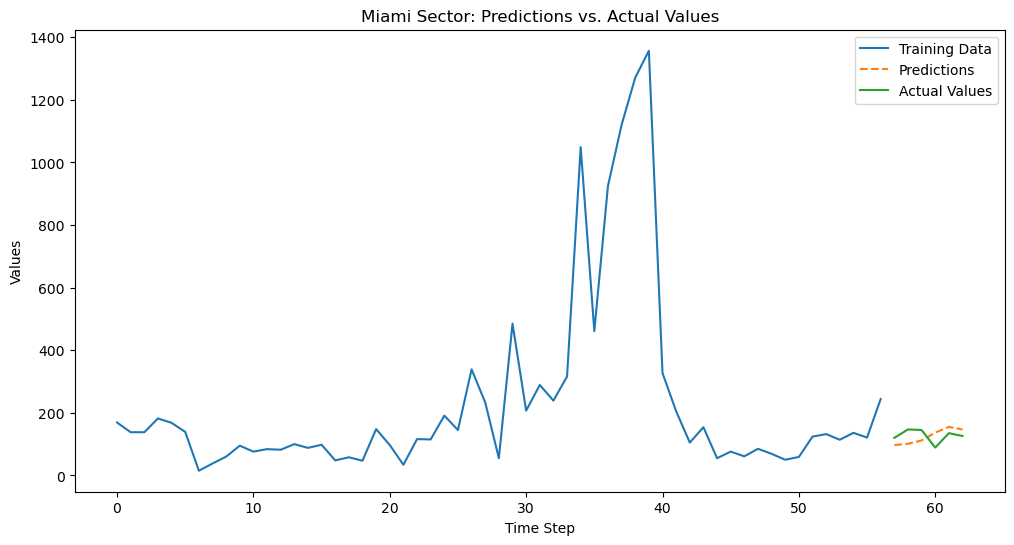

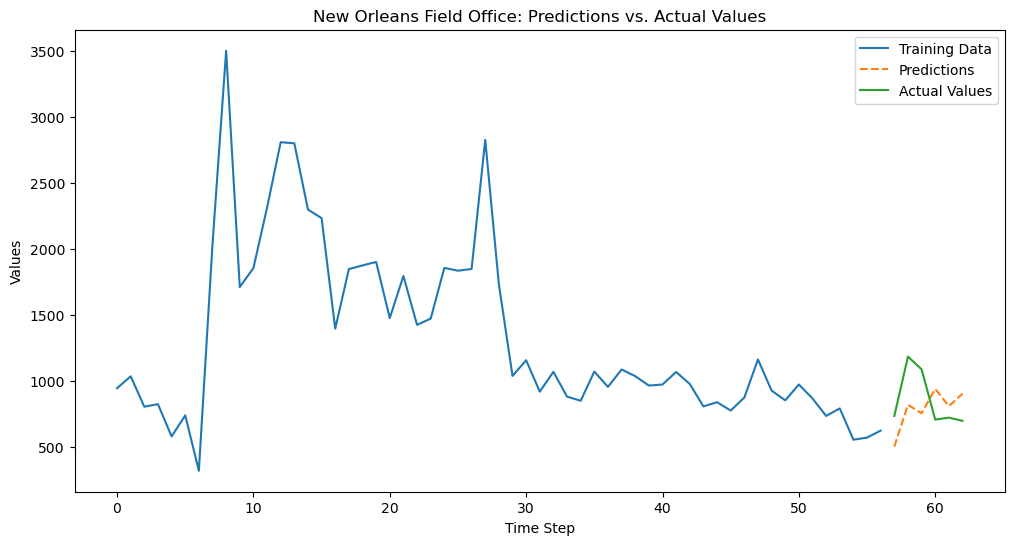

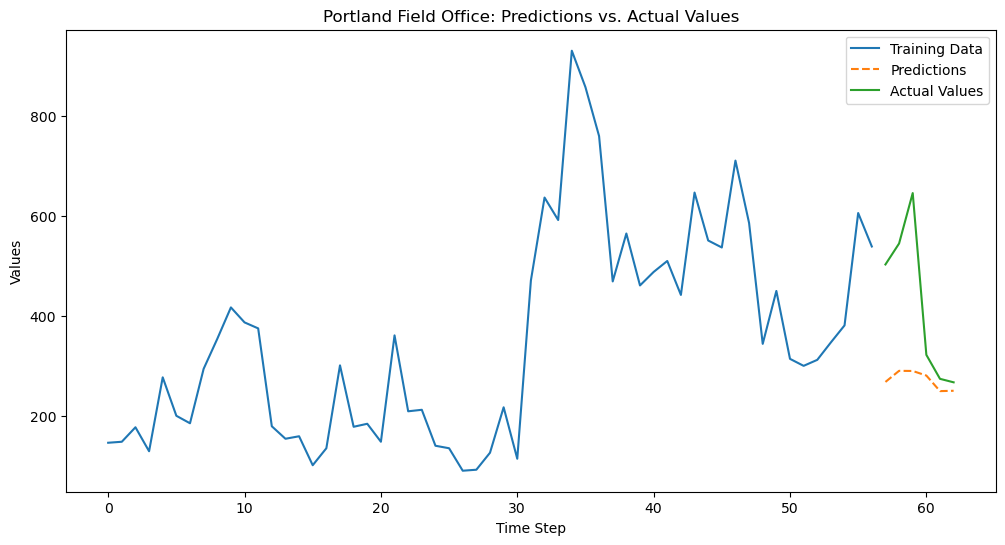

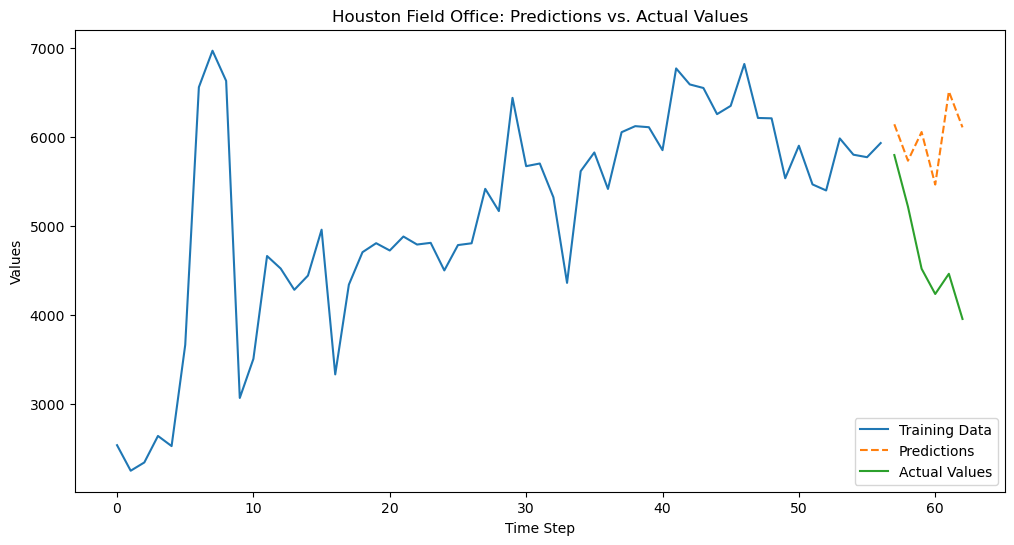

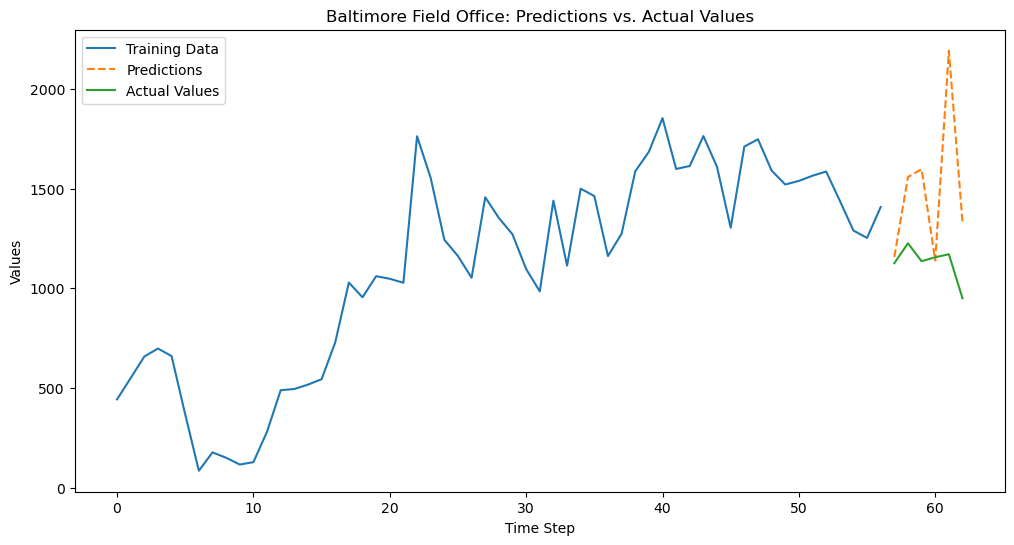

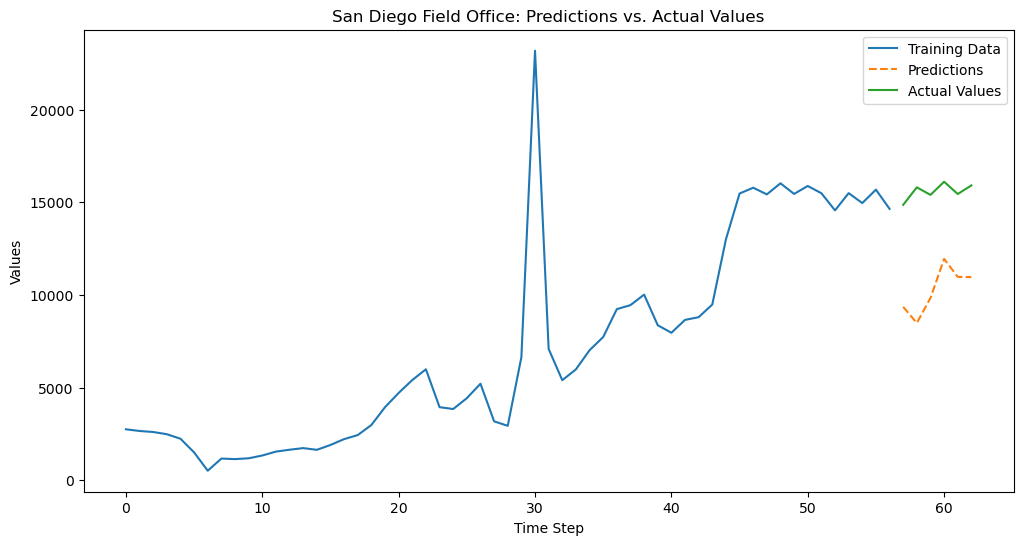

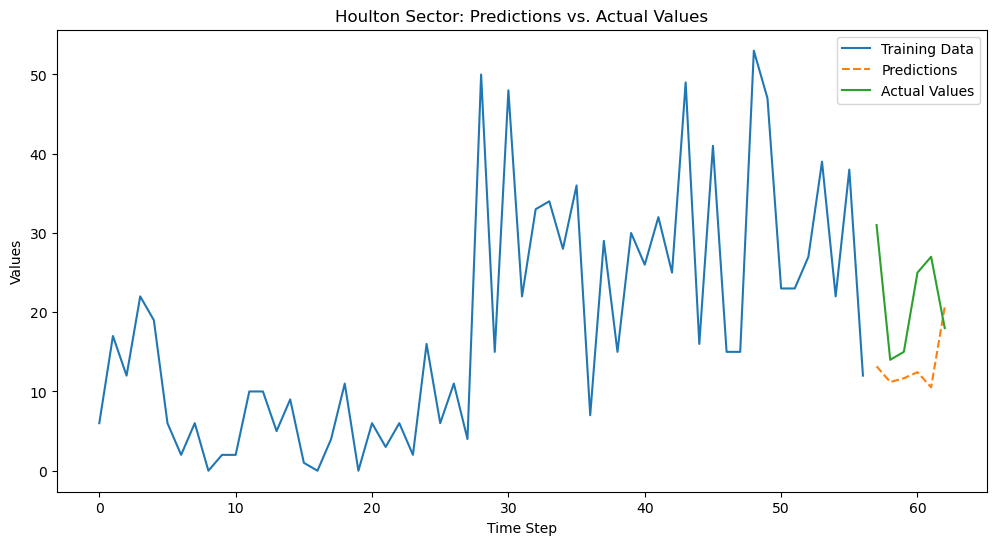

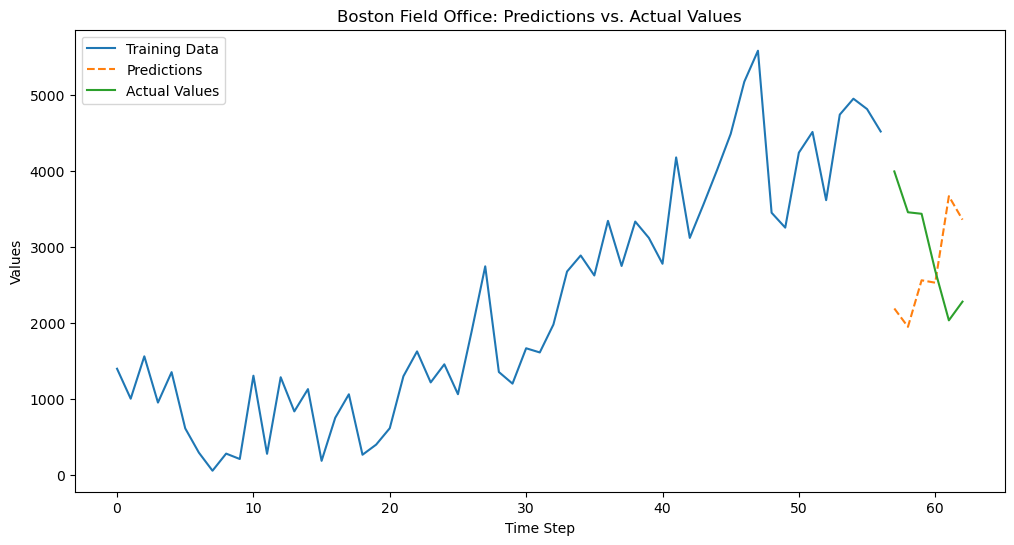

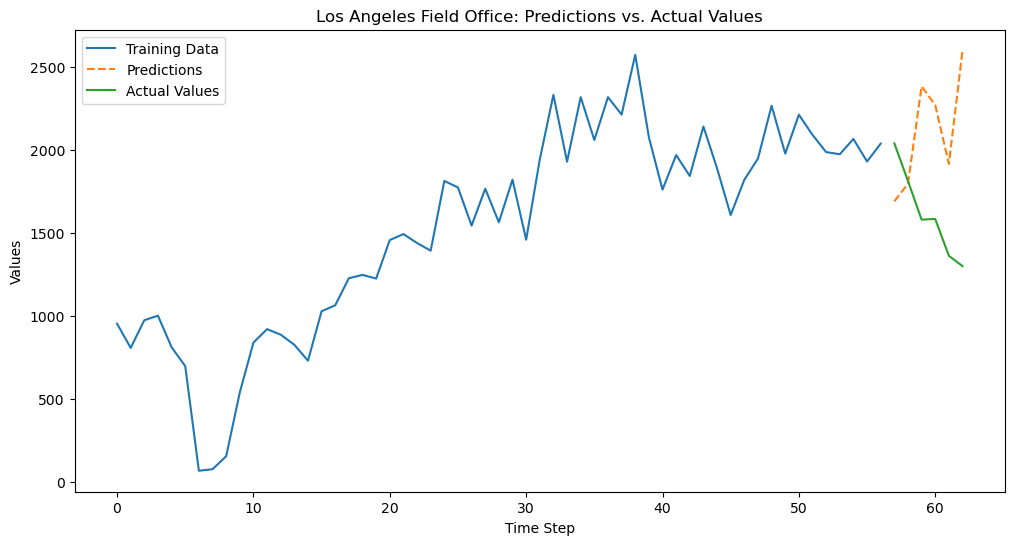

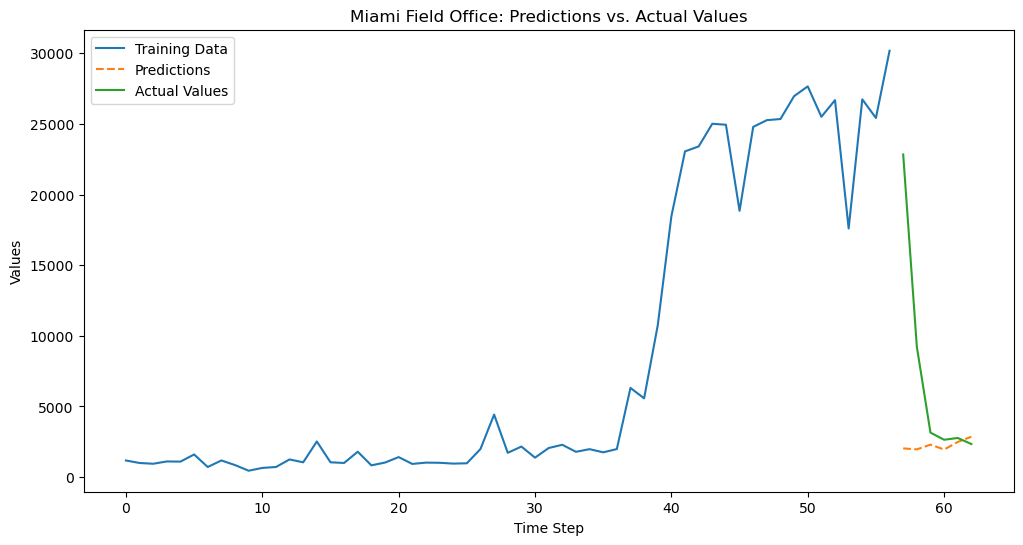

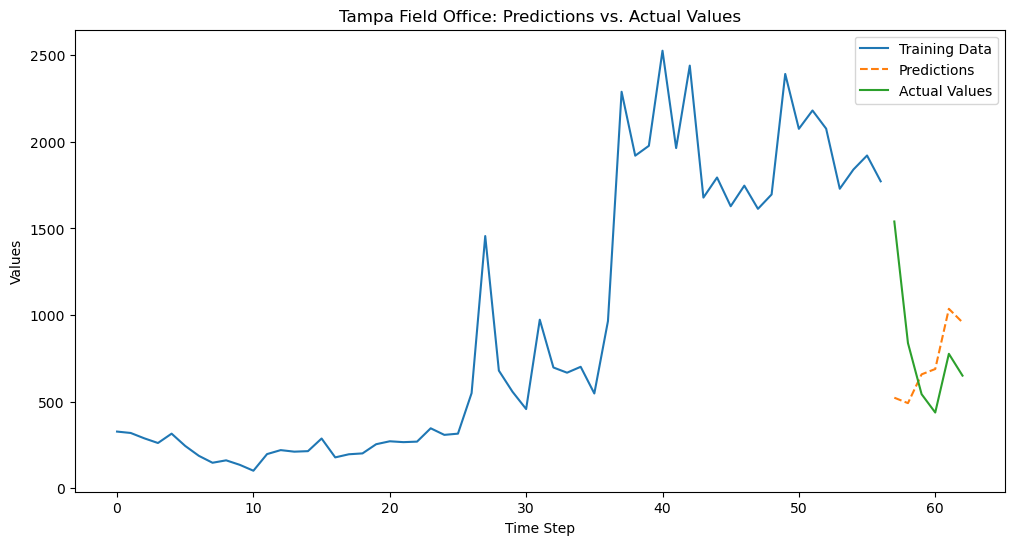

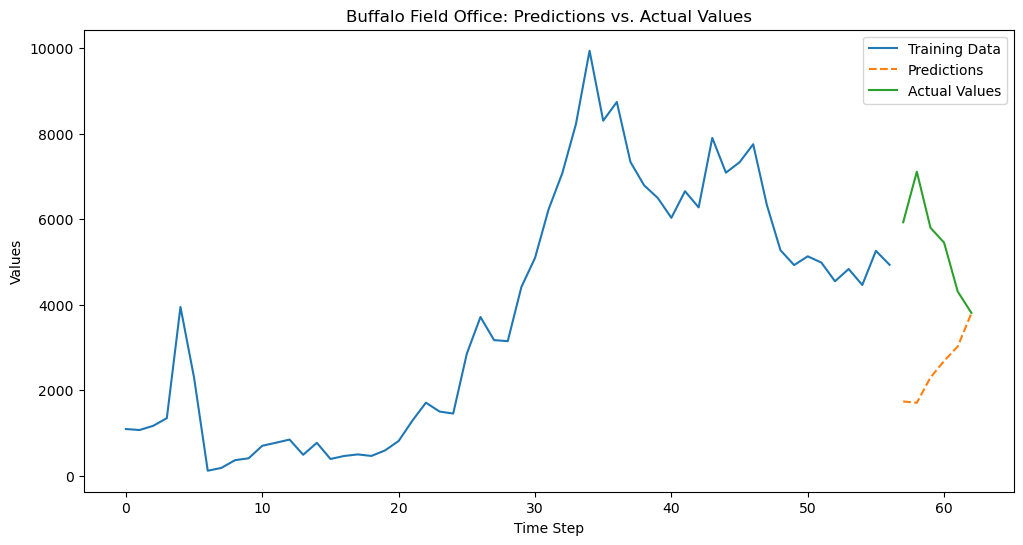

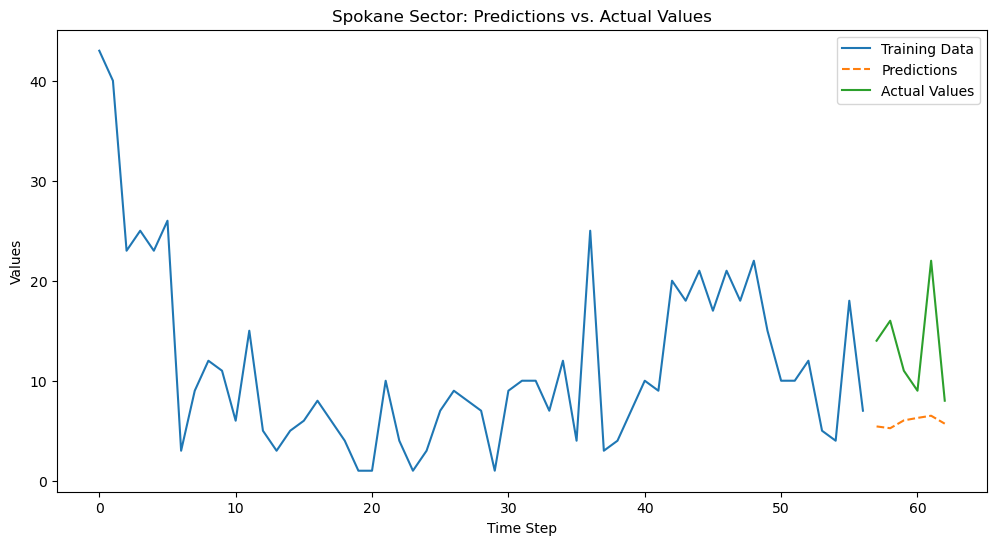

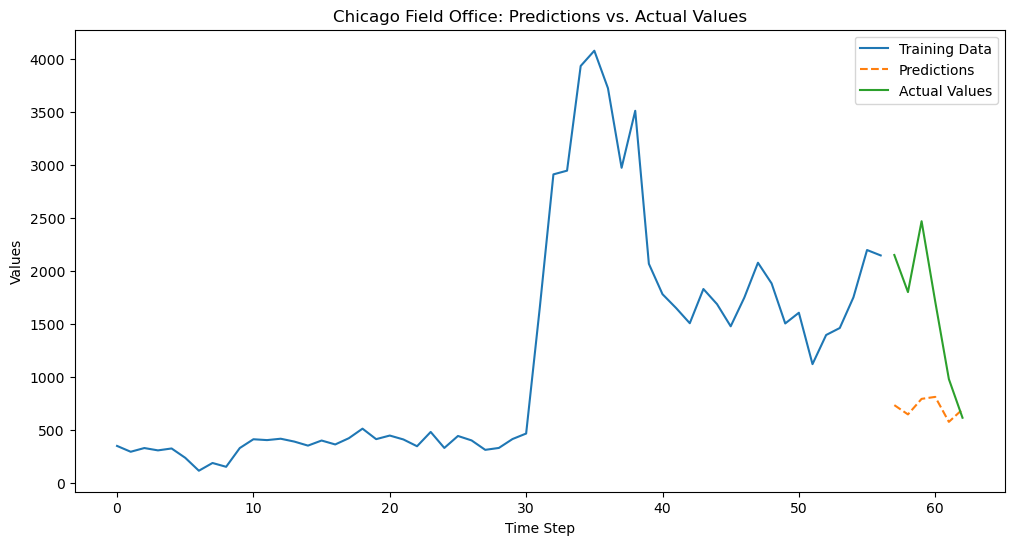

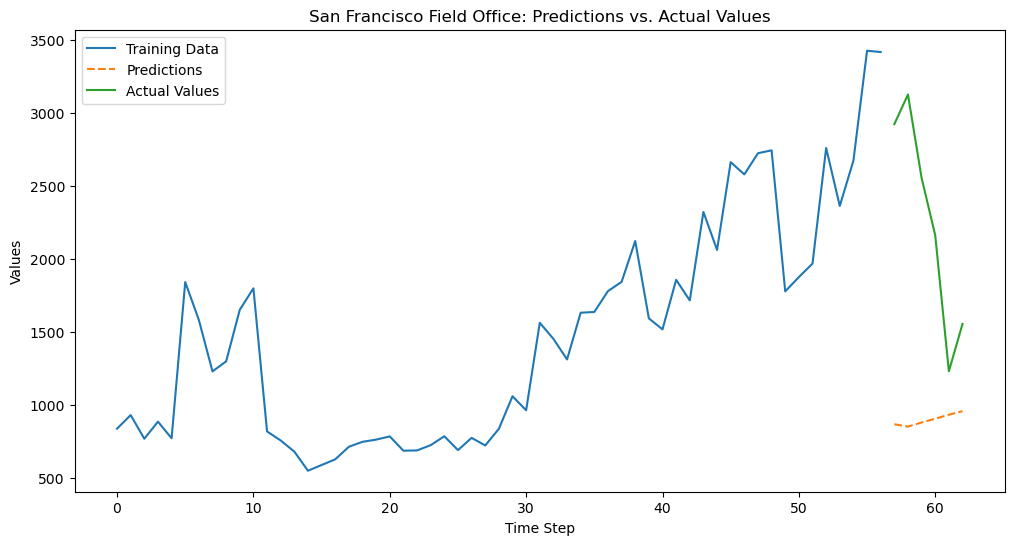

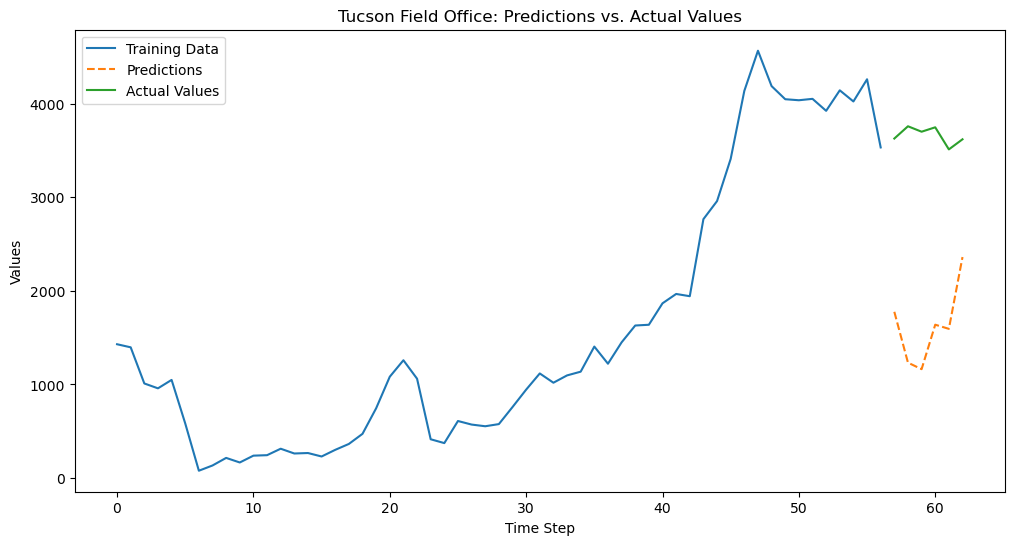

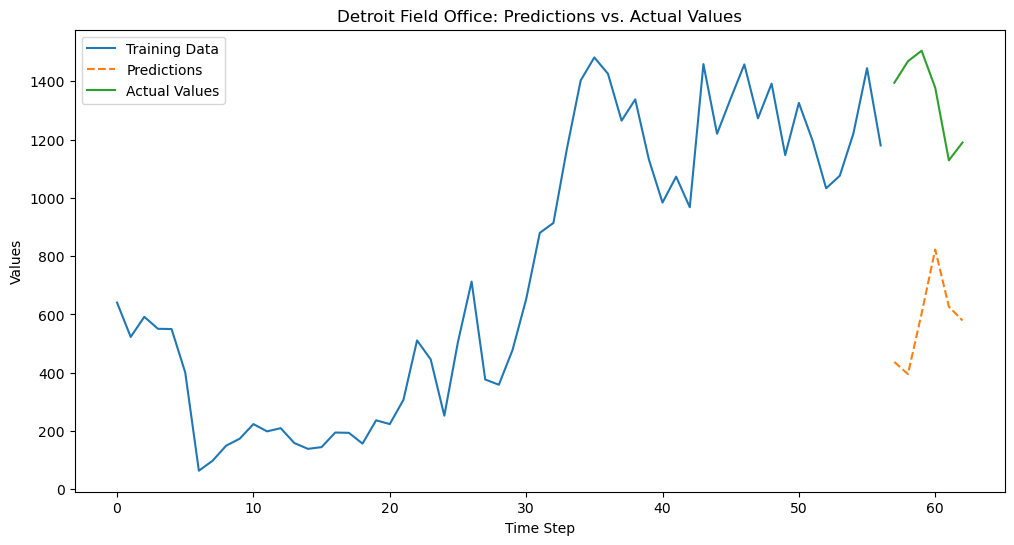

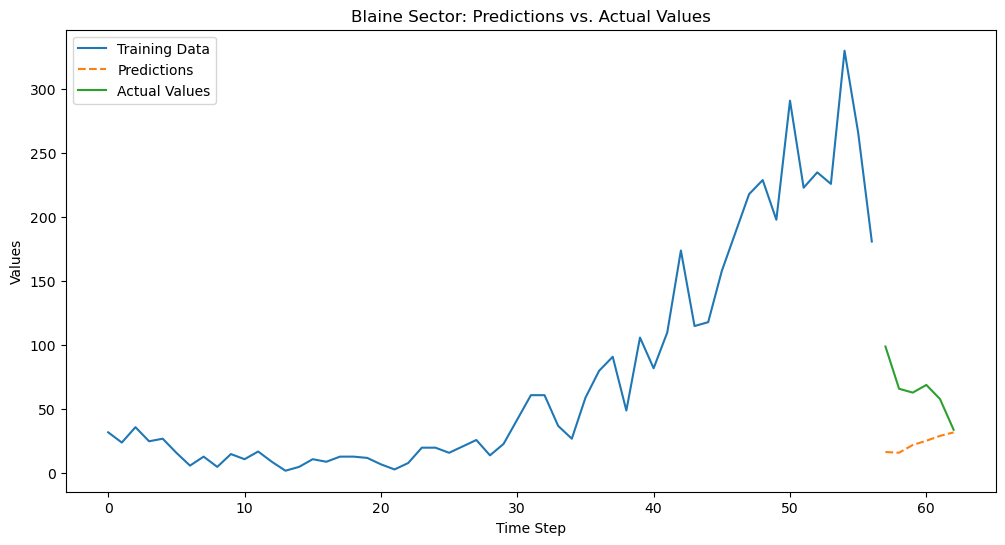

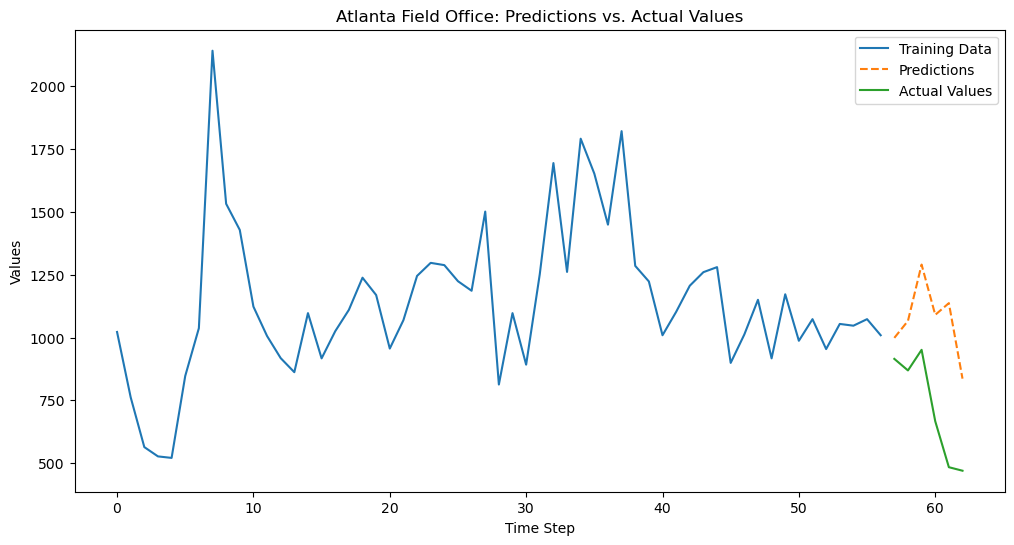

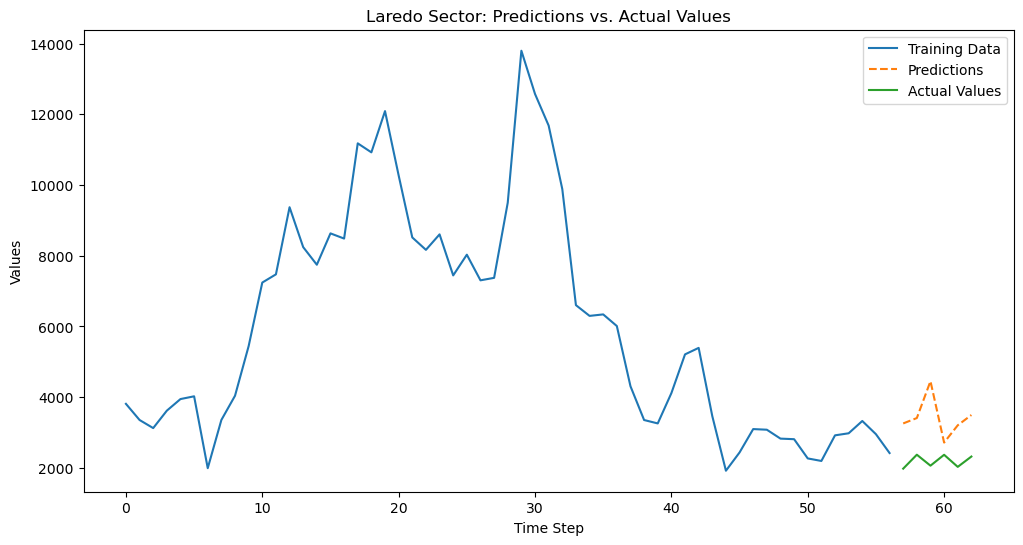

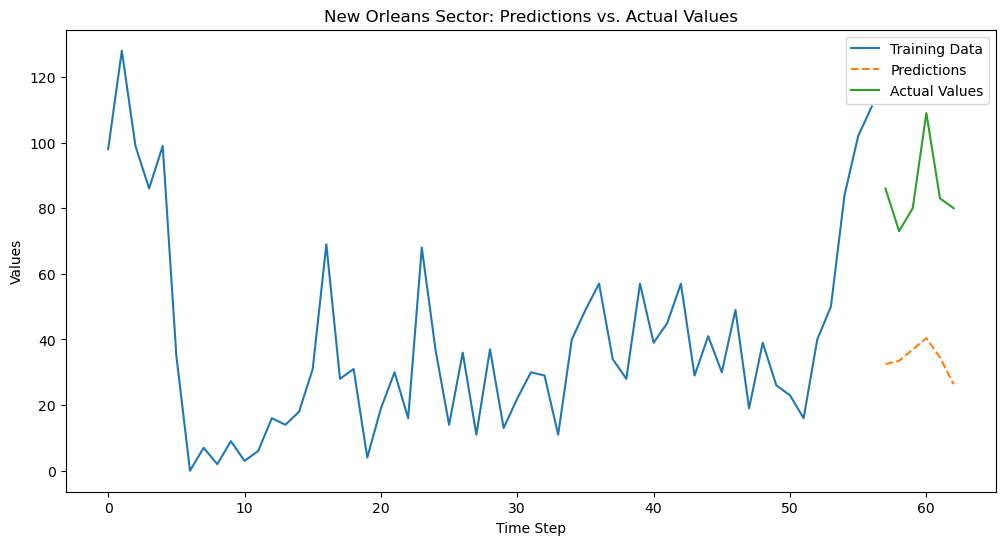

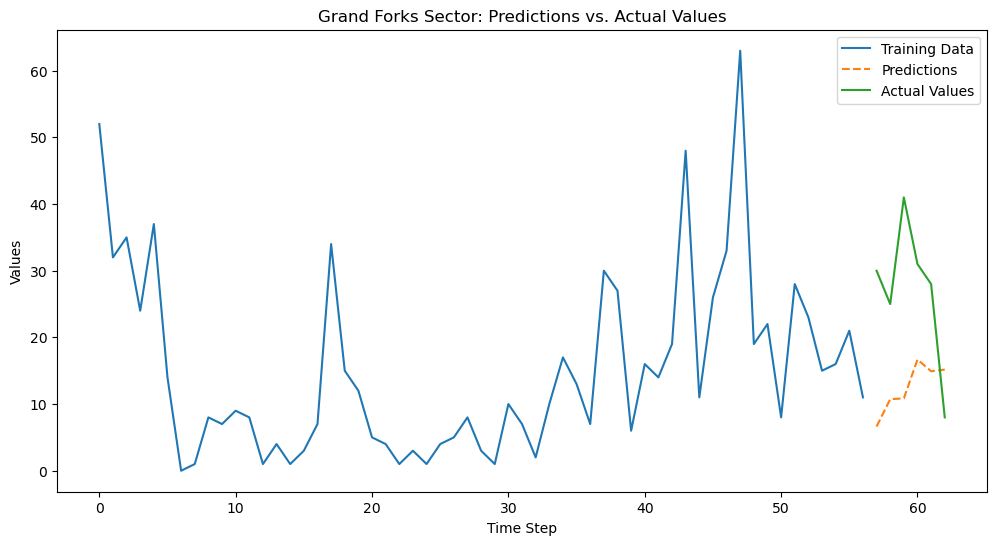

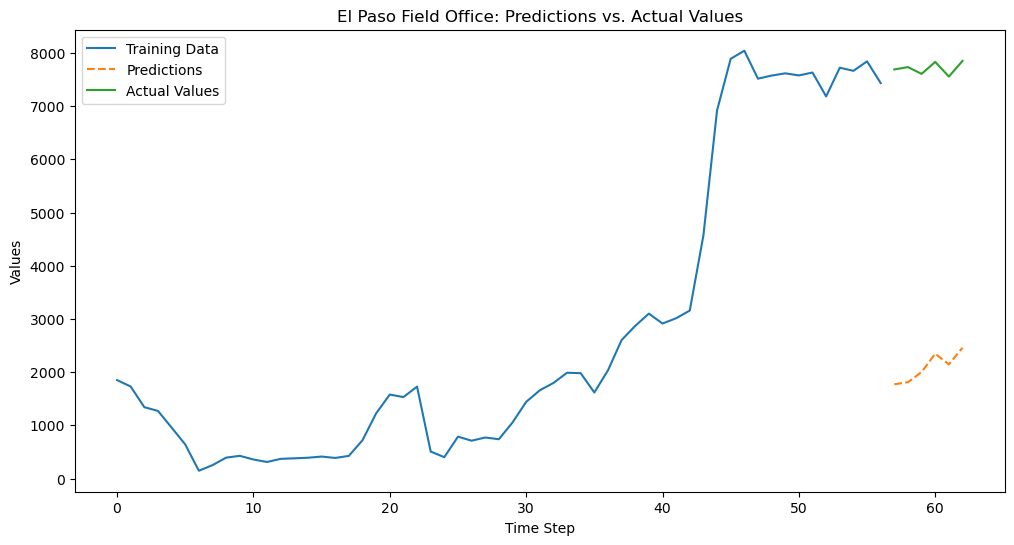

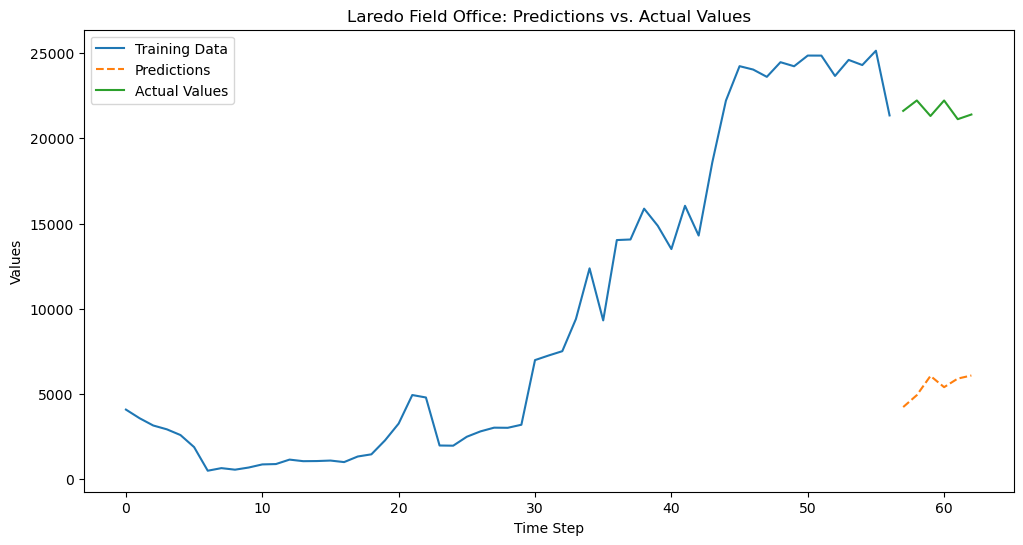

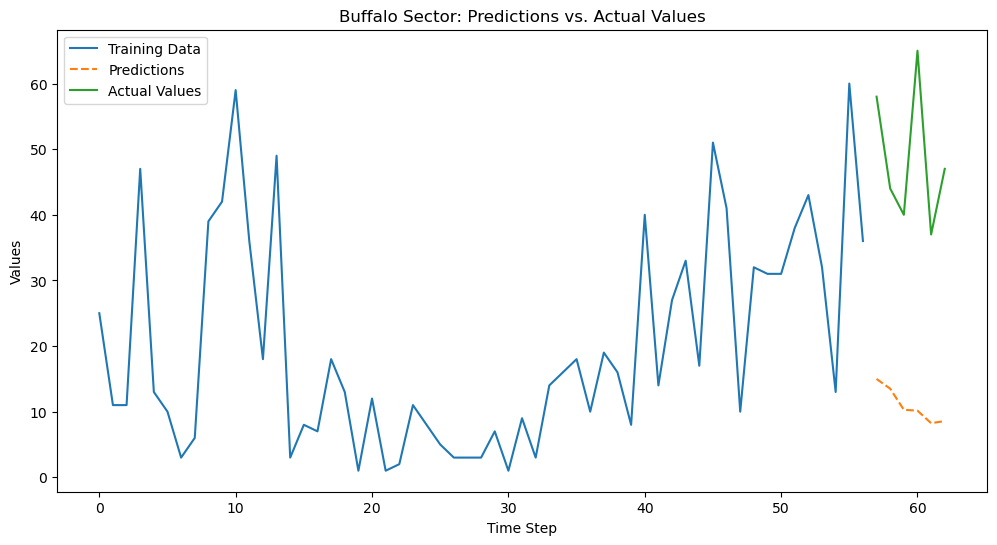

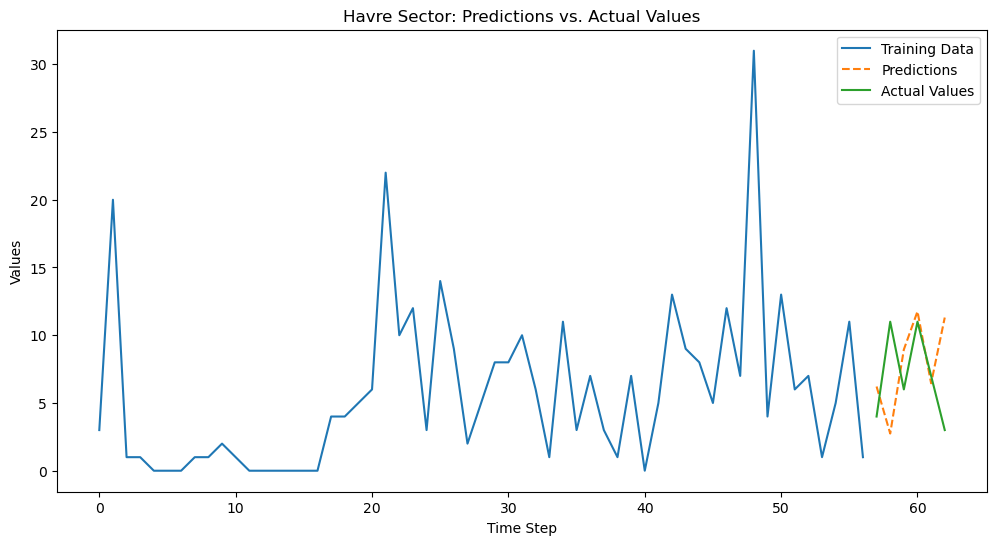

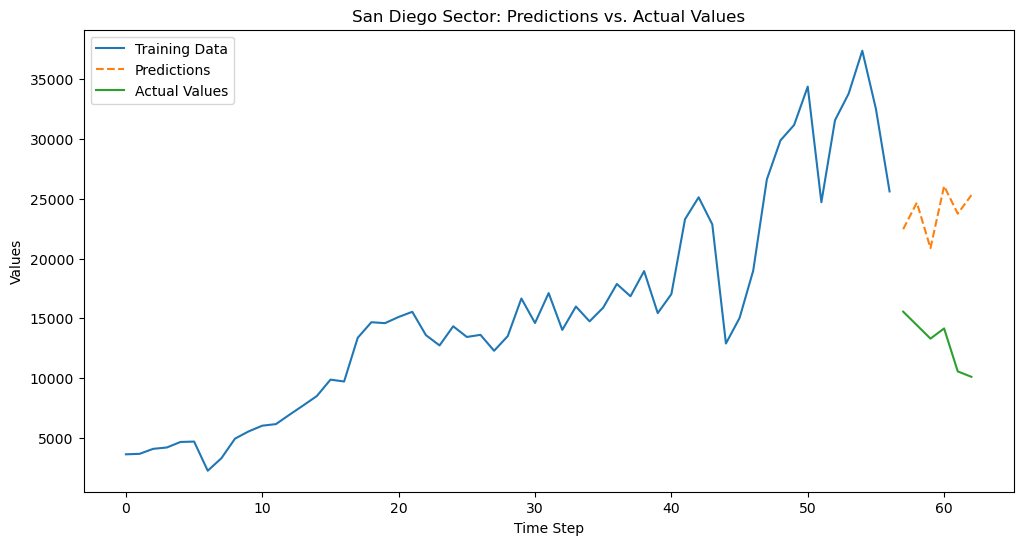

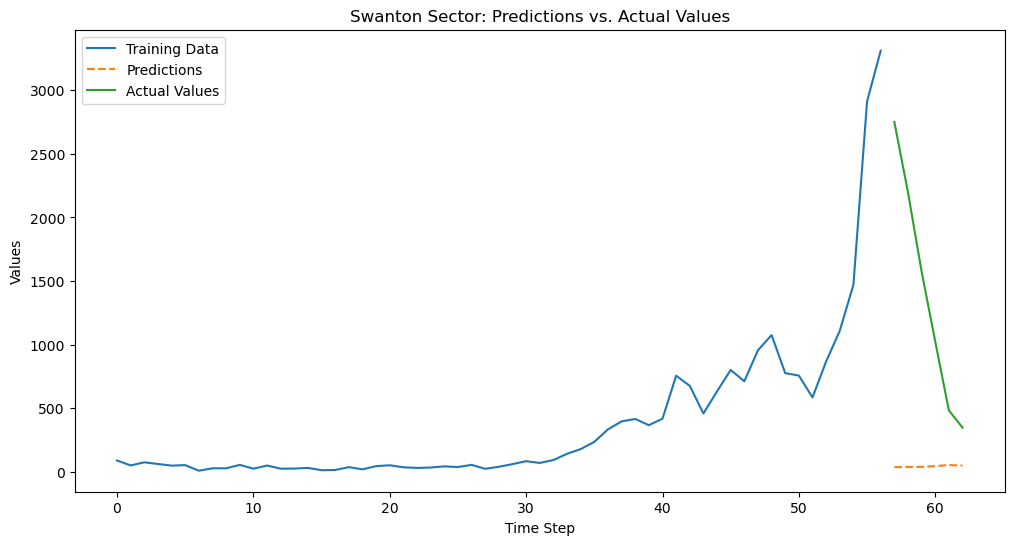

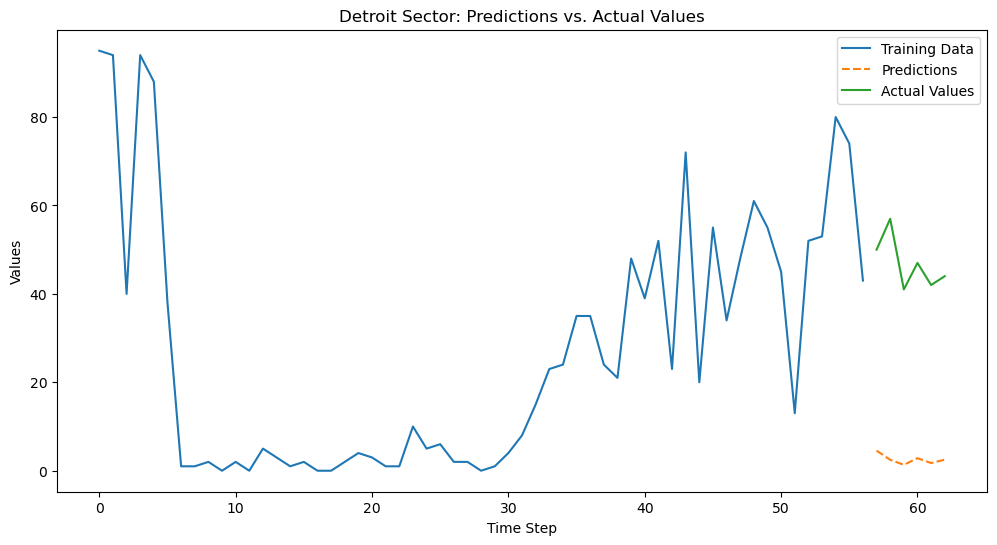

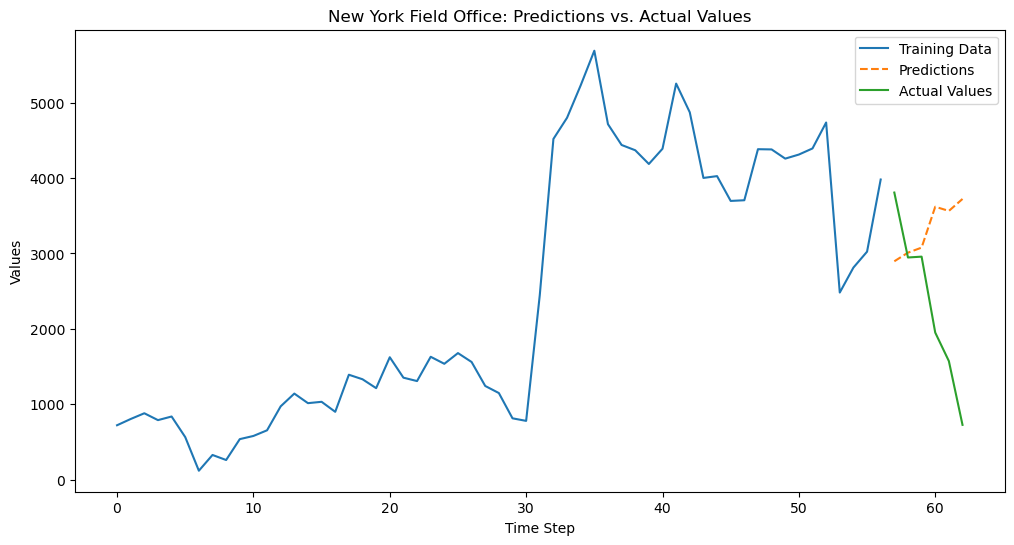

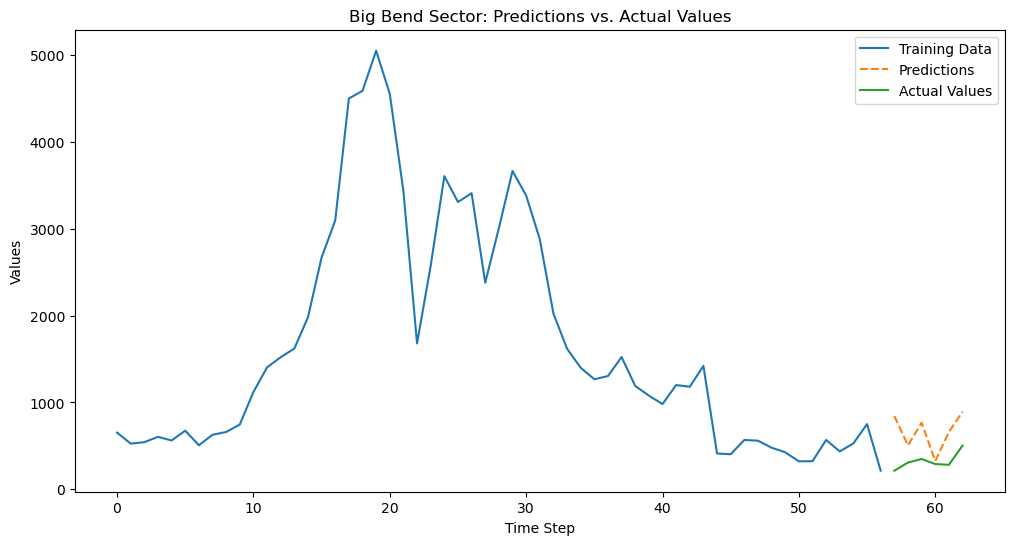

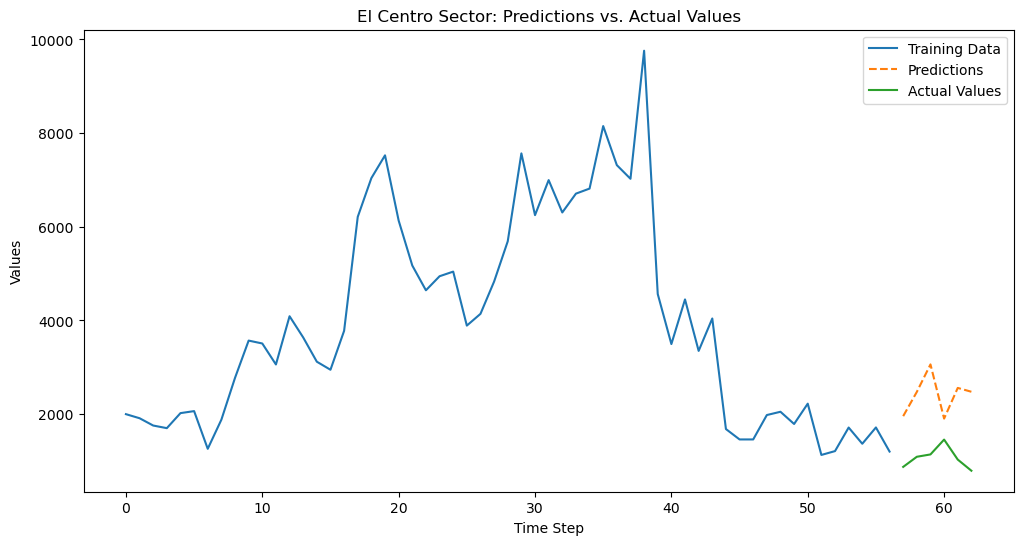

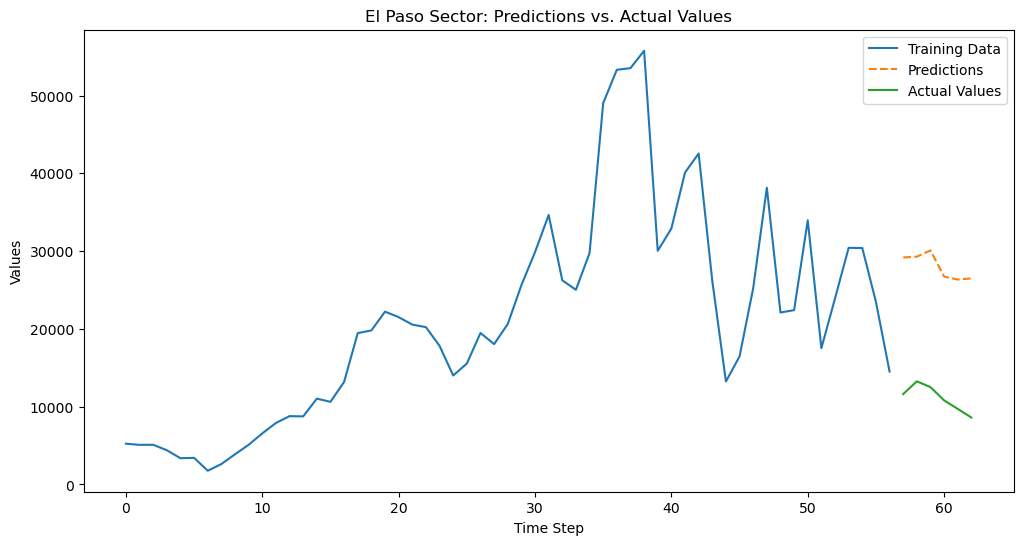

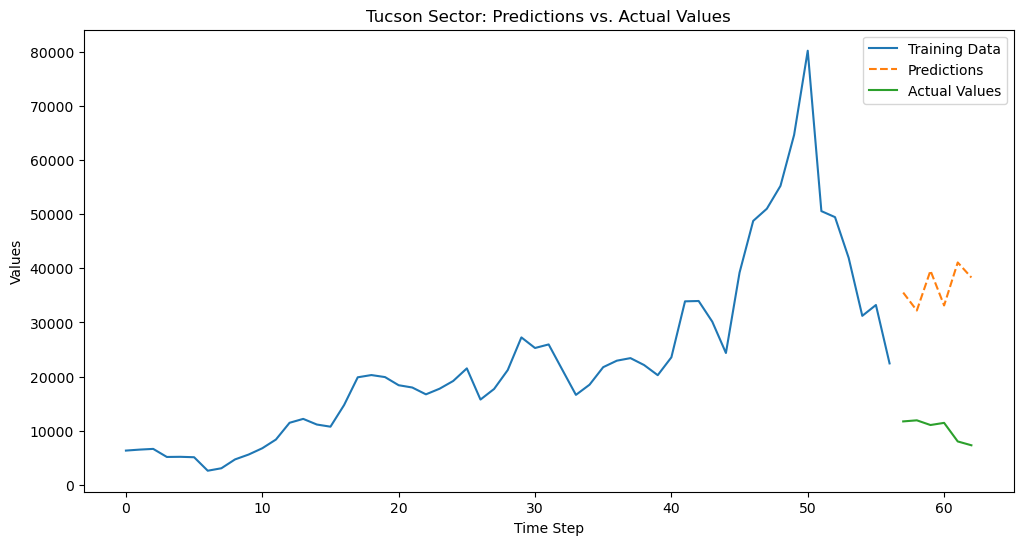

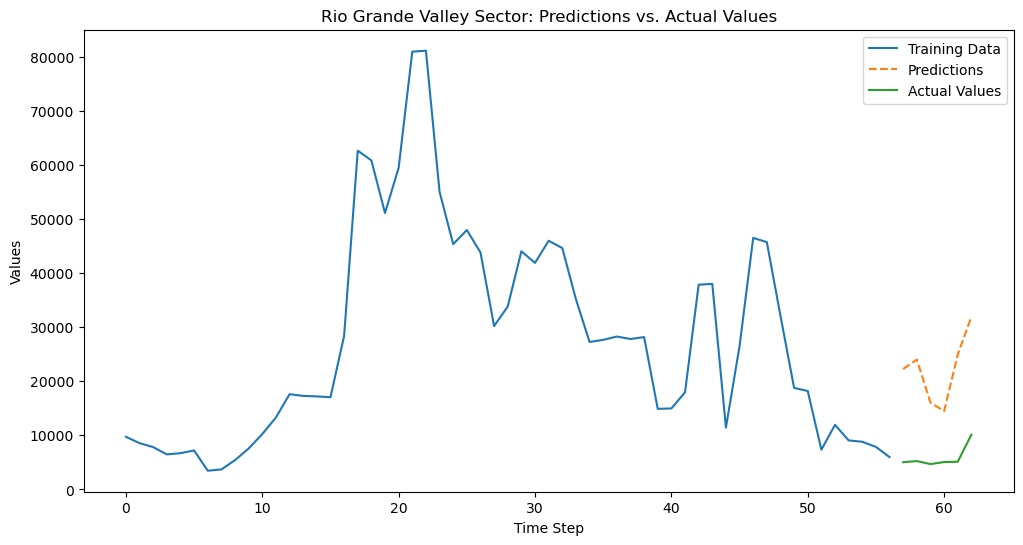

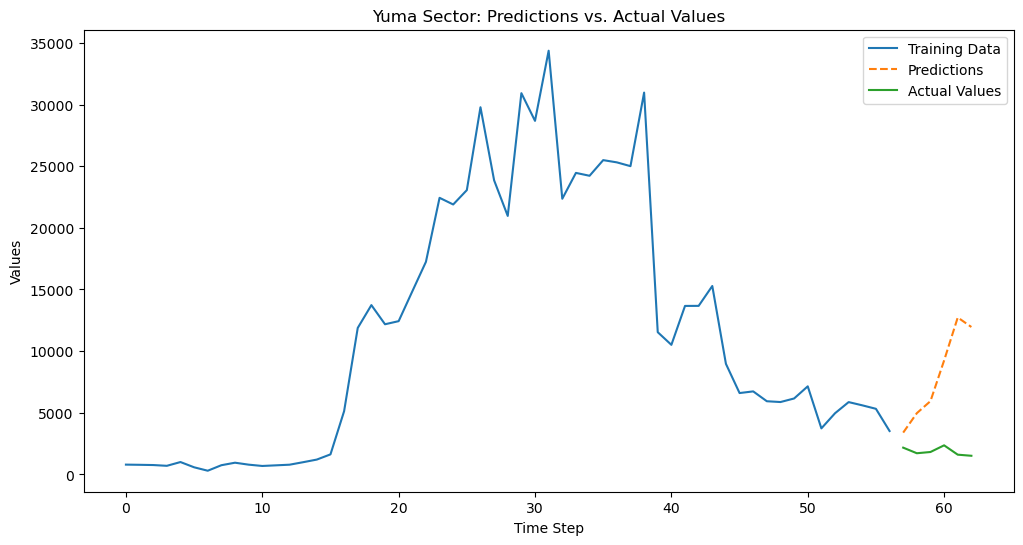

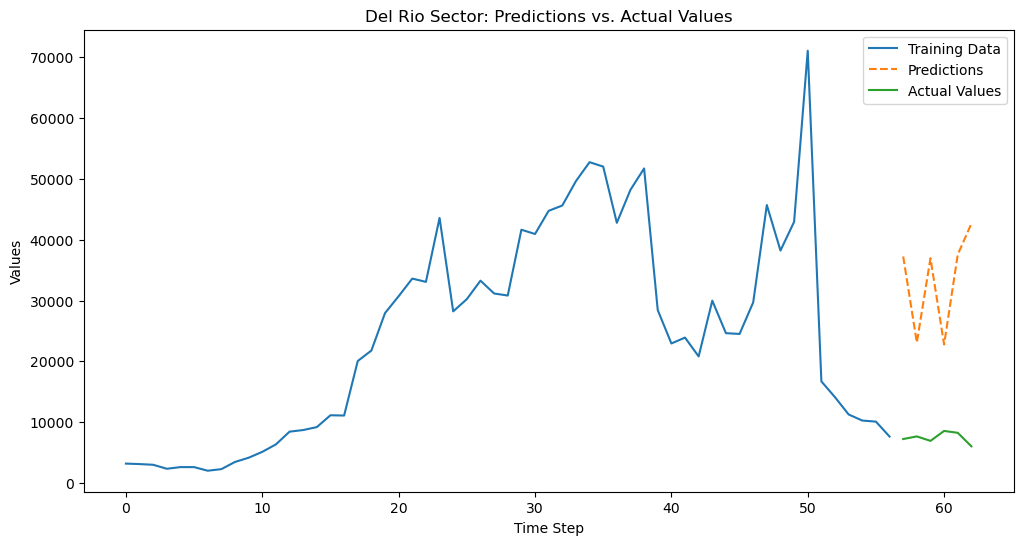

In [ ]:
# Calculate the mean MAPE for each sector
mean_mape_per_sector = lstm_model_results.groupby('sector')['MAPE'].apply(lambda x: np.mean([item for sublist in x for item in sublist]))

# Find the top 5 sectors with the lowest mean MAPE
top_5_sectors = mean_mape_per_sector.nsmallest(40).index

# Plot predictions vs. actual values for the top 5 sectors
for sector in top_5_sectors:
    sector_results = lstm_model_results[lstm_model_results['sector'] == sector]

    # Extract predictions and actual values
    sector_predictions = np.concatenate(sector_results['predictions'].values)
    sector_actual = test_data.loc[sector].values[:len(sector_predictions)]
    sector_actual_train = sector_train.loc[sector].values

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(sector_actual_train, label='Training Data')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_predictions)), sector_predictions, label='LSTM Predictions', linestyle='--')
    plt.plot(range(len(sector_actual_train), len(sector_actual_train) + len(sector_actual)), sector_actual, label='Actual Values')
    plt.title(f'{sector}: Predictions vs. Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()